In [0]:
from google.colab import drive
import tensorflow as tf
import numpy as np
import pandas as pd

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load Data

I know it says "validation_data" but it was only used to validate the ANN, NOT VeGAN or any other models. VeGAN never saw the validation data during training.

This code loads 15 random samples of seasons to be used to test all approaches.

In [0]:
test = pd.read_csv('gdrive/My Drive/sbgan/validation_data.csv', index_col=0)

In [0]:
samples = []
for i in range(15):
  samples[i] = test.sample(5120)

# Random Approach

This approach takes random upsets and bets on them. It's a random baseline for comparison with VeGAN.

In [0]:
def compute_ran_accuracy(picks, out):
  num_right = 0
  num_picked = np.sum(picks)
  for p, o in zip(picks, out):
    if p == 1 and o == 1:
      num_right += 1
  return num_right / num_picked

def compute_ran_profit(picks, odds, out, max_wager=1.):
  odds = 1. / odds
  total = 0
  for p, odd, vic in zip(picks, odds[:, 0], out[:, 0]):
    wager = p * max_wager
    total += (wager * odd * vic) - wager
  return total

In [0]:
def get_random_results(samples):
  ran_acc = []
  ran_prof = []
  for sample in samples:
    sample = test.sample(5120)
    underdogs = sample[(sample['ODDS'] >= 2.)]
    X_underdogs, underdog_odds, underdog_outcomes = underdogs.drop(['ODDS', 'OUTCOME'], axis=1).to_numpy(), 1. / underdogs[['ODDS']].to_numpy(), underdogs[['OUTCOME']].to_numpy()
    picks = np.random.randint(2, size=underdog_outcomes.shape[0])
    ran_acc.append(compute_ran_accuracy(picks, underdog_outcomes))
    ran_prof.append(compute_ran_profit(picks, underdog_odds, underdog_outcomes))
  return ran_acc, ran_prof

In [0]:
ran_acc, ran_prof = get_random_results(samples)
ran_acc_df = pd.DataFrame(data=ran_acc, columns=['Season Accuracy'])
ran_prof_df = pd.DataFrame(data=ran_prof, columns=['Season Profit'])
ran_acc_df.describe()

,Season Accuracy
count,15.000000
mean,0.302828
std,0.011207
min,0.285362
25%,0.293374
50%,0.302230
75%,0.313420
max,0.320388


In [0]:
ran_prof_df.describe()

,Season Profit
count,15.000000
mean,-94.809333
std,48.083213
min,-184.380000
25%,-131.280000
50%,-89.890000
75%,-55.780000
max,-24.390000


# Naive Approach

We'll take two naive approaches: fixed bets on the underdog and fixed bets on the favorite. The fixed bet will be 5 units.

In [0]:
def naive_profit(games):
  total = 0
  df = pd.DataFrame(columns=['ODDS', 'OUTCOME'])
  df['ODDS'] = games['ODDS']
  df['OUTCOME'] = games['OUTCOME']
  for i, game in enumerate(df.values):
    odds, outcome = game
    wager = 1
    total += (odds * outcome * wager) - wager
  return total

In [0]:
def get_naive_results(samples):
  favorite_accuracy = []
  favorite_profit = []
  underdogs_accuracy = []
  underdogs_profit = []

  for sample in samples:
    favorites = sample[sample['ODDS'] < 2]
    underdogs = sample[sample['ODDS'] >= 2]

    favorite_accuracy.append(favorites[favorites['OUTCOME'] == 1].shape[0] / favorites.shape[0])
    underdogs_accuracy.append(underdogs[underdogs['OUTCOME'] == 1].shape[0] / underdogs.shape[0])

    favorite_profit.append(naive_profit(favorites))
    underdogs_profit.append(naive_profit(underdogs))
  return (favoriate_accuracy, favorite_profit), (underdogs_accuracy, underdogs_profit)

In [0]:
(favorite_accuracy, favorite_profit), (underdogs_accuracy, underdogs_profit) = get_naive_results(samples)
fav_acc_df = pd.DataFrame(data=favorite_accuracy, columns=['Season Accuracy'])
fav_prof_df = pd.DataFrame(data=favorite_profit, columns=['Season Profit'])
und_acc_df = pd.DataFrame(data=underdogs_accuracy, columns=['Season Accuracy'])
und_prof_df = pd.DataFrame(data=underdogs_profit, columns=['Season Profit'])

In [0]:
fav_acc_df.describe()

,Season Accuracy
count,15.000000
mean,0.678065
std,0.002781
min,0.671970
25%,0.676739
50%,0.678422
75%,0.680461
max,0.681099


In [0]:
und_acc_df.describe()

,Season Accuracy
count,15.000000
mean,0.304547
std,0.002637
min,0.299521
25%,0.303574
50%,0.304716
75%,0.306175
max,0.309524


In [0]:
fav_prof_df.describe()

,Season Profit
count,15.000000
mean,-116.060926
std,11.536758
min,-138.843115
25%,-123.315322
50%,-115.301518
75%,-106.610818
max,-102.041067


In [0]:
und_prof_df.describe()

,Season Profit
count,15.000000
mean,-177.130000
std,25.389111
min,-230.770000
25%,-194.450000
50%,-167.380000
75%,-160.410000
max,-141.890000


# ANN

The ANN model is in the "Binary Classification Bettor" notebook. It just predicts the probability that a matchup comes true.

In [0]:
ann = tf.keras.models.load_model('gdrive/My Drive/sbgan/binary')

In [0]:
def compute_ann_accuracy(scores, outcomes):
  scores = np.round(scores)
  num_right = 0
  for score, out in zip(scores, outcomes):
    if score == out:
      num_right += 1
  return num_right / len(outcomes)

def compute_ann_flat_profit(scores, odds, outcomes, max_wager=1.):
  scores = np.round(scores)
  odds = 1. / odds
  total = 0
  for p, odd, vic in zip(scores, odds[:, 0], outcomes[:, 0]):
    wager = p * max_wager
    winnings = (wager * vic * odd) - wager
    total += winnings
  return total

def compute_ann_kelly_profit(scores, odds, outcomes, max_wager=1):
  winnings = []
  for p, odd, vic in zip(scores, odds, outcomes):
    p = p[0]
    q = 1 - p
    b = 1. / odd
    kelly = max(0, (b*p - q) / b)
    wager = kelly * max_wager
    winnings.append((vic * wager * b) - wager)
  return np.sum(np.array(winnings))

In [0]:
def get_ann_results(samples):
  ann_accuracy = []
  flat_profit = []
  kelly_profit = []
  for sample in samples:
    X, odds, outcome = sample.drop(['ODDS', 'OUTCOME'], axis=1).to_numpy(), 1. / sample[['ODDS']].to_numpy(), sample[['OUTCOME']].to_numpy()
    scores = ann.predict(X)

    ann_accuracy.append(compute_ann_accuracy(scores, outcome))
    flat_profit.append(compute_ann_flat_profit(scores, odds, outcome))
    kelly_profit.append(compute_ann_kelly_profit(scores, odds, outcome))
  return ann_accuracy, flat_profit, kelly_profit

In [0]:
ann_accuracy, flat_profit, kelly_profit = get_ann_results(samples)
ann_acc_df = pd.DataFrame(data=ann_accuracy, columns=['Season Accuracy'])
ann_prof_flat_df = pd.DataFrame(data=flat_profit, columns=['Season Flat Profit'])
ann_prof_kelly_df = pd.DataFrame(data=kelly_profit, columns=['Season Kelly Profit'])

In [0]:
ann_acc_df.describe()

,Season Accuracy
count,15.000000
mean,0.637214
std,0.002565
min,0.633984
25%,0.635254
50%,0.636328
75%,0.638770
max,0.641602


In [0]:
ann_prof_flat_df.describe()

,Season Flat Profit
count,15.000000
mean,-107.806677
std,14.909282
min,-137.661072
25%,-115.452881
50%,-108.941902
75%,-98.695446
max,-80.606773


In [0]:
ann_prof_kelly_df.describe()

,Season Kelly Profit
count,15.000000
mean,-66.306287
std,7.865210
min,-78.730609
25%,-71.259138
50%,-68.053841
75%,-60.456483
max,-54.613586


# Upset Detection

I had to define the model in here because TensorFlow is weird with saving custom models like this one. 

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import os

class VeGAN():

  # Tweaked from Keras GAN: https://github.com/eriklindernoren/Keras-GAN
  def __init__(self, optimizer='rmsprop'):

    self.G = self.build_generator()
    
    self.D = self.build_discriminator()
    self.D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
    inp = Input(shape=(174,))
    odds = self.G(inp)

    valid = self.D(inputs=[inp, odds])

    self.combined = Model(inp, valid)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  # Tweaked from Keras GAN: https://github.com/eriklindernoren/Keras-GAN
  def build_generator(self):
    inp = Input(shape=(174,))
    
    fc1 = Dense(128)(inp)
    fc1 = LeakyReLU(alpha=0.2)(fc1)
    fc1 = BatchNormalization(momentum=0.8)(fc1)

    fc2 = Dense(64)(fc1)
    fc2 = LeakyReLU(alpha=0.2)(fc2)

    odds = Dense(1, activation='sigmoid')(fc2)

    return Model(inp, odds)
  
  # Tweaked from Keras GAN: https://github.com/eriklindernoren/Keras-GAN
  def build_discriminator(self):

    inp = Input(shape=(174,))
    odds = Input(shape=(1,))

    fc1 = Dense(128)(inp)
    fc1 = LeakyReLU(alpha=0.2)(fc1)
    fc1 = Dropout(0.2)(fc1)

    fc2 = Dense(64)(fc1)
    fc2 = LeakyReLU(alpha=0.2)(fc2)
    fc2 = Dropout(0.2)(fc2)

    combined = K.concatenate([fc2, odds])
  
    pred = Dense(1, activation='sigmoid')(combined)

    return Model(inputs=[inp, odds], outputs=pred)
  
  def save_weights(self, path):
    d_path = os.path.join(path, 'discriminator.h5')
    g_path = os.path.join(path, 'generator.h5')
    self.G.save_weights(g_path)
    self.D.save_weights(d_path)

  def load_weights(self, d_path, g_path):
    self.G.load_weights(g_path)
    self.D.load_weights(d_path)

  # From Keras AnoGAN: https://github.com/tkwoo/anogan-keras/blob/master/anogan.py
  def feature_extractor(self):
    intermediate = Model(inputs=self.D.layers[0].input, outputs=self.D.layers[-7].output)
    intermediate.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermediate
  
  # From Keras AnoGAN: https://github.com/tkwoo/anogan-keras/blob/master/anogan.py
  def sum_of_residual(self, y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

  # From Keras ANOGan: https://github.com/tkwoo/anogan-keras/blob/master/anogan.py
  def anomaly_detector(self):
    fe = self.feature_extractor()
    fe.trainable = False
    g = Model(inputs=self.G.layers[1].input, outputs=self.G.layers[-1].output)
    g.trainable = False

    aInp = Input(shape=(174,))
    gInp = Dense((174), activation='sigmoid', trainable=True)(aInp)

    gOut = g(gInp)
    dOut = fe([aInp, gOut])

    model = Model(inputs=aInp, outputs=[gOut, dOut])
    model.compile(loss=self.sum_of_residual, loss_weights=[0.9, 0.1], optimizer='rmsprop')
    
    K.set_learning_phase(0)

    return model

  # From Keras ANOGan: https://github.com/tkwoo/anogan-keras/blob/master/anogan.py
  def compute_anomaly_score(self, model, x, y, iterations=500):
      intermediate = self.feature_extractor()
      d_x = intermediate.predict([x, y])

      loss = model.fit(x, [y, d_x], batch_size=1, epochs=iterations, verbose=0)
      similar_data, _ = model.predict(x)
      
      loss = loss.history['loss'][-1]
      
      return loss, similar_data

  def compute_anomaly_scores(self, model, x, y, iterations=500):
    upset_scores = []

    for line, odd in zip(X_underdogs, underdog_odds):
      score, _ = vegas.compute_anomaly_score(model, np.array([line]), np.array([odd]))
      upset_scores.append(score)

    return np.array(upset_scores)
  
  # Tweaked from Keras GAN: https://github.com/eriklindernoren/Keras-GAN
  def train(self, X_train, y_train, results=None, epochs=10, batch_size=128):
    history = {'d_loss': [], 'g_loss': []}
  
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
      
      if epoch+1 % 20000 == 0:
        self.D.trainable = False
    
      idx = np.random.randint(0, X_train.shape[0], batch_size)

      games = X_train[idx]
      outcomes = results[idx]
  
      gen_odds = self.G.predict(games)
      odds = y_train[idx]
      accept = self.D.predict([games, gen_odds])

      d_loss_real = self.D.train_on_batch([games, odds], valid)
      d_loss_fake = self.D.train_on_batch([games, gen_odds], fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      history['d_loss'].append(d_loss[0])

      g_loss = self.combined.train_on_batch(games, valid)
      history['g_loss'].append(g_loss)
    
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      
    return history

In [0]:
vegas = VeGAN()
vegas.load_weights('gdrive/My Drive/sbgan/discriminator.h5', 'gdrive/My Drive/sbgan/generator.h5')

In [0]:
def compute_upset_accuracy(scores, out, threshold=4.):
  num_right = 0
  num_picked = 0
  for score, vic in zip(scores, out):
    if score > threshold:
      num_picked += 1
      if vic == 1:
        num_right += 1
  return num_right / num_picked

def compute_upset_flat_profit(scores, odds, out, threshold=4.2, max_wager=1.):
  odds = 1. / odds
  total = 0
  for score, odd, out in zip(scores, odds[:, 0], out[:, 0]):
    if score > threshold:
      winnings = (max_wager * odd * out) - max_wager
      total += winnings
  
  return total

def compute_upset_mixed_profit(scores, odds, out):
  odds = 1./ odds
  total = 0
  for score, odd, out in zip(scores, odds[:, 0], out[:, 0]):
    winnings = (score * odd * out) - score
    total += winnings
  
  return total

In [0]:
# This initally only recorded profits not accuracy, but now it also reports accuracy
def get_multi_upset_results(model, data, n=15):
  thresholds = [4.0 + i*0.2 for i in range(0, 11)]
  profits = {}
  accuracy = {}
  for t in thresholds:
    profits[str(t)] = []
    accuracy[{}] = []
  
  for i in range(n):
    print("Testing Sample: %d" % i)
    sample = data.sample(5120)
    underdogs = sample[(sample['ODDS'] >= 2.)]
    X_underdogs, underdog_odds, underdog_outcomes = underdogs.drop(['ODDS', 'OUTCOME'], axis=1).to_numpy(), 1. / underdogs[['ODDS']].to_numpy(), underdogs[['OUTCOME']].to_numpy()
    scores = vegas.compute_anomaly_scores(model, X_underdogs, underdog_odds)
    for t in thresholds:
      profits[str(t)].append(compute_upset_profit(scores, underdog_odds, underdog_outcomes, threshold=t))
      accuracy[str(t)].append(compute_upset_accuracy(scores, underdog_outcomes, threshold=t))
    
  return accuracy, profits

In [0]:
vegan_accuracy, vegan_profits = get_multi_upset_results(upset_detector, test)
vegan_profits_df = pd.DataFrame(vegan_profits)
vegan_accuracy_df = pd.DataFrame(vegan_accuracy)

# Plot Results

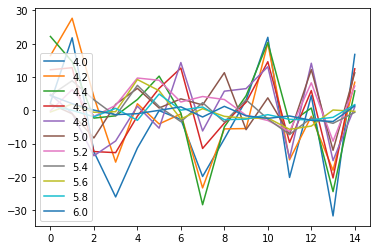

In [0]:
import matplotlib.pyplot as plt
plt.plot('x', '4.0', data=vegan_profits_df)
plt.plot('x', '4.2', data=vegan_profits_df)
plt.plot('x', '4.4', data=vegan_profits_df)
plt.plot('x', '4.6', data=vegan_profits_df)
plt.plot('x', '4.8', data=vegan_profits_df)
plt.plot('x', '5.0', data=vegan_profits_df)
plt.plot('x', '5.2', data=vegan_profits_df)
plt.plot('x', '5.4', data=vegan_profits_df)
plt.plot('x', '5.6', data=vegan_profits_df)
plt.plot('x', '5.8', data=vegan_profits_df)
plt.plot('x', '6.0', data=vegan_profits_df)
plt.legend()

In [0]:
vegan_profits.to_csv('gdrive/My Drive/sbgan/vegan_profits.csv')
vegan_accuracy.to_csv('gdrive/My Drive/sbgan/vegan_accuracy.csv')